This notebook analyzes the results of the wandb sweeps. It is used to generate the plots in the paper.

## Imports


In [1]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# wandb.init(project="6DimCachespliteinSweep", entity="st7ma784")
entity, project = "st7ma784", "6DIMCLIPTOKSweepvfinal6.0DIM"  # set to your entity and project 

api = wandb.Api()
runs = api.runs(entity + "/" + project) 

# runs = runs.filter("config.learning_rate = 0.0005")
# runs = runs.filter("config.batch_size = 10")
# runs = runs.filter("config.precision = 32")
# runs = runs.filter("config.maskLosses = 0")
# runs = runs.filter("config.embed_dim = 512")
# runs = runs.filter("config.transformer_width = 512")
# runs = runs.filter("config.transformer_heads = 16")
# runs = runs.filter("config.transformer_layers = 24")
# runs = runs.filter("config.prune = False")
# runs = runs.filter("config.meanloss = True")

# runs = runs.filter("config.logitsversion = 0")
# runs = runs.filter("config.projection = ''")

# runs = runs.filter("state = finished")
# print("found",len(runs),"runs")



summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary=run.summary._json_dict
    #filter to just the keys of 
    key_set=set(["improbe","textprobe","train_loss","val_loss","first_logit"])
    summary={k:summary[k] for k in key_set if k in summary}
    summary_list.append(summary)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })
#show the dataframe

print(runs_df.to_latex())



/home/user/miniconda3/envs/open-ce/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


\begin{tabular}{llll}
\toprule
{} &                                summary &                                             config &                    name \\
\midrule
0  &        \{'train\_loss': 13932.708984375\} &  \{'JSE': 0, 'dir': '/data', 'dims': 6, 'debug':... &            solar-sea-32 \\
1  &      \{'train\_loss': 3.458843231201172\} &  \{'JSE': 0, 'dir': '/data', 'dims': 6, 'debug':... &          desert-wood-31 \\
2  &          \{'train\_loss': 8126.68359375\} &  \{'JSE': 0, 'dir': '/data', 'dims': 6, 'debug':... &           icy-vortex-30 \\
3  &      \{'train\_loss': 2.810676336288452\} &  \{'JSE': 0, 'dir': '/data', 'dims': 6, 'debug':... &          wild-sunset-29 \\
4  &     \{'train\_loss': 2.8677778244018555\} &  \{'JSE': 0, 'dir': '/data', 'dims': 6, 'debug':... &     celestial-violet-28 \\
5  &                  \{'train\_loss': 'NaN'\} &  \{'JSE': 0, 'dir': '/data', 'dims': 6, 'debug':... &       olive-capybara-27 \\
6  &             \{'train\_loss': 3141957.25\} &  \{'J

/tmp/ipykernel_3220195/395805533.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(runs_df.to_latex())


In [3]:


from sys import version


image_dims_list,text_dims_list= {}, {}
image_version_list,text_version_list= {}, {}

for run in runs: 
    #group runs by dims and record range of linear probe accuracy
    dims = run.config["dims"]
    version=run.config["logitsversion"]
    summary=run.summary._json_dict
    text_dims_list[dims] = text_dims_list.get("dims", []) + (summary["TProbe"])
    image_dims_list[dims] = image_dims_list.get("dims", []) + (summary["ImProbe"])
    text_version_list[version] = text_version_list.get("version", []) + (summary["TProbe"])
    image_version_list[version] = image_version_list.get("version", []) + (summary["ImProbe"])
    

#for each dims, compute mean and range of linear probe accuracy
text_dims_mean = {k: np.mean(v) for k,v in text_dims_list.items()}
text_dims_range = {k: np.max(v) - np.min(v) for k,v in text_dims_list.items()}
text_dims_std = {k: np.std(v) for k,v in text_dims_list.items()}
text_dims_count = {k: len(v) for k,v in text_dims_list.items()}

image_dims_mean = {k: np.mean(v) for k,v in image_dims_list.items()}
image_dims_range = {k: np.max(v) - np.min(v) for k,v in image_dims_list.items()}
image_dims_std = {k: np.std(v) for k,v in image_dims_list.items()}
image_dims_count = {k: len(v) for k,v in image_dims_list.items()}

text_version_mean = {k: np.mean(v) for k,v in text_version_list.items()}
text_version_range = {k: np.max(v) - np.min(v) for k,v in text_version_list.items()}
text_version_std = {k: np.std(v) for k,v in text_version_list.items()}
text_version_count = {k: len(v) for k,v in text_version_list.items()}

image_version_mean = {k: np.mean(v) for k,v in image_version_list.items()}
image_version_range = {k: np.max(v) - np.min(v) for k,v in image_version_list.items()}
image_version_std = {k: np.std(v) for k,v in image_version_list.items()}
image_version_count = {k: len(v) for k,v in image_version_list.items()}

#make the results into a dataframes: column headers are dims with each key split into image and text and the rows are mean, range, std, and count

dims_df = pd.DataFrame({
    "text_mean": text_dims_mean,
    "text_range": text_dims_range,
    "text_std": text_dims_std,
    "text_count": text_dims_count,
    "image_mean": image_dims_mean,
    "image_range": image_dims_range,
    "image_std": image_dims_std,
    "image_count": image_dims_count
    }) 
#print(dims_df.to_latex())

version_df = pd.DataFrame({
    "text_mean": text_version_mean,
    "text_range": text_version_range,
    "text_std": text_version_std,
    "text_count": text_version_count,
    "image_mean": image_version_mean,
    "image_range": image_version_range,
    "image_std": image_version_std,
    "image_count": image_version_count
    })
# print(version_df.to_latex())
version_df

KeyError: 'textprobe'

['_attrs', 'client', '_entity', 'project', '_files', '_base_dir', 'sweep', '_include_sweeps', 'dir', '_summary', '_state', 'user', '__module__', '__doc__', '__init__', 'state', 'entity', 'username', 'storage_id', 'id', 'name', 'create', 'load', 'wait_until_finished', 'update', 'delete', 'save', 'json_config', '_exec', '_sampled_history', '_full_history', 'files', 'file', 'upload_file', 'history', 'scan_history', 'logged_artifacts', 'used_artifacts', 'use_artifact', 'log_artifact', 'summary', 'path', 'url', 'lastHistoryStep', 'to_html', '_repr_html_', '__repr__', 'snake_to_camel', 'display', '__getattr__', '__dict__', '__weakref__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
run-9w32bh56-ImEmbeddings:v0


wandb:   1 of 1 files downloaded.  


./artifacts/run-9w32bh56-ImEmbeddings:v0
run-9w32bh56-ImEmbeddings:v1


wandb: Downloading large artifact run-9w32bh56-ImEmbeddings:v1, 924.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


./artifacts/run-9w32bh56-ImEmbeddings:v1
run-9w32bh56-ImEmbeddings:v2


wandb: Downloading large artifact run-9w32bh56-ImEmbeddings:v2, 926.31MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


./artifacts/run-9w32bh56-ImEmbeddings:v2
run-9w32bh56-ImEmbeddings:v3


wandb: Downloading large artifact run-9w32bh56-ImEmbeddings:v3, 926.25MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


./artifacts/run-9w32bh56-ImEmbeddings:v3
run-9w32bh56-ImEmbeddings:v4


wandb: Downloading large artifact run-9w32bh56-ImEmbeddings:v4, 925.97MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


./artifacts/run-9w32bh56-ImEmbeddings:v4
run-9w32bh56-ImEmbeddings:v5


wandb: Downloading large artifact run-9w32bh56-ImEmbeddings:v5, 925.39MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


./artifacts/run-9w32bh56-ImEmbeddings:v5
run-9w32bh56-ImEmbeddings:v6


wandb: Downloading large artifact run-9w32bh56-ImEmbeddings:v6, 925.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


./artifacts/run-9w32bh56-ImEmbeddings:v6


/tmp/ipykernel_4026845/1294018525.py:55: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=image_embeddings_df, hist=False, label = "version "+str(i))
/tmp/ipykernel_4026845/1294018525.py:55: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=image_embeddings_df, hist=False, label =

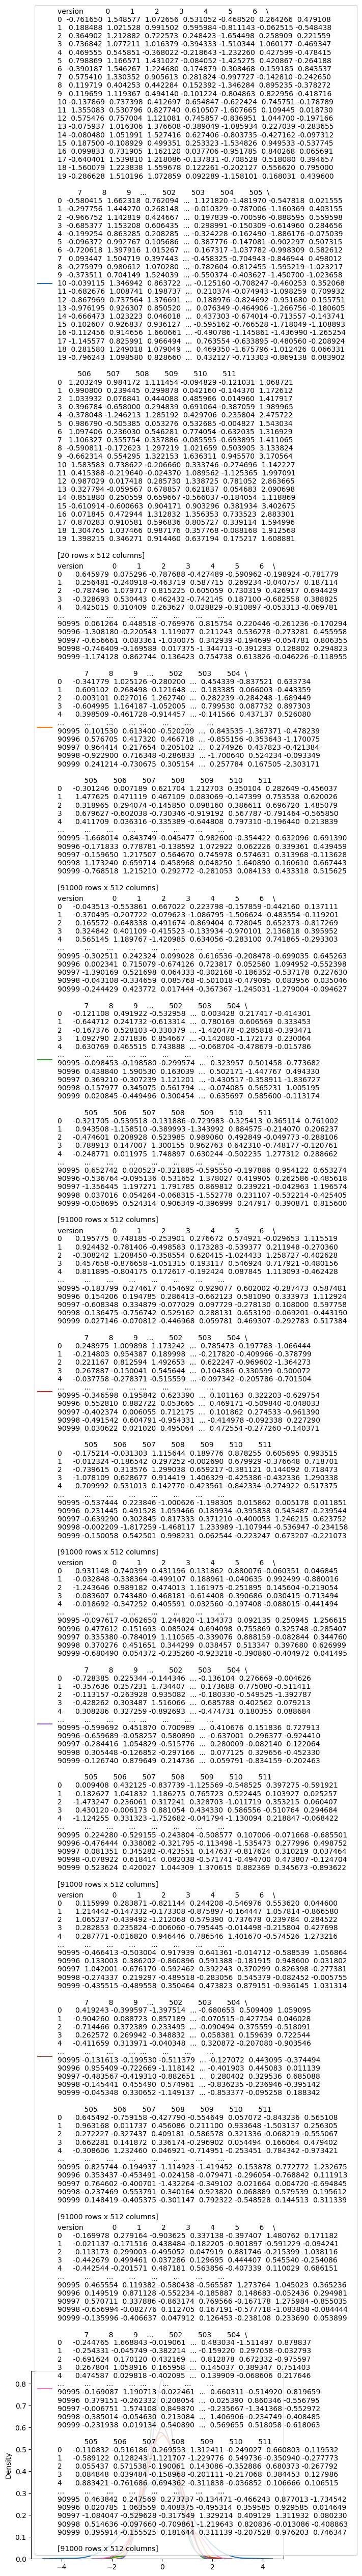

In [2]:
# we're going to explore the embeddings created at st7ma784 / 6DIMCLIPTOKSweepv4 / artifacts / run_table / run-9w32bh56-ImEmbeddings 
# we'll use the wandb python api to download the embeddings and then use pandas to load them into a dataframe
# we'll then use seaborn to plot the embeddings in 2d space
import wandb
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# download the embeddings
api = wandb.Api()
run = api.run("st7ma784/6DIMCLIPTOKSweepv4/9w32bh56")
#get the artifact
# find all the artifacts generated by this run with logged_artifacts
print(run.__dir__())
artifacts = run.logged_artifacts()
artifacts=[ artifacts[i] for i in range(0,14,2)]
image_dataframes = []
text_dataframes = []
for artifact in artifacts:
    print(artifact.name)
    #download the artifact
    artifact_dir = artifact.download()
    print(artifact_dir)
    if artifact.name.split(":")[0].endswith("ImEmbeddings"):

        with open(str(os.path.join(artifact_dir, "Im Embeddings.table.json"))) as file:
            im_embeddings=json.load(file)
            #print keys
            #print(im_embeddings.keys())
            #convert to dataframe
            #print(im_embeddings["data"])
            im_embeddings_df = pd.DataFrame(im_embeddings["data"])
            #print(im_embeddings_df)
            #ADD TO LIST
            image_dataframes.append(im_embeddings_df)
    else:
        with open(str(os.path.join(artifact_dir, "Text Embeddings.table.json"))) as file:
            text_embeddings=json.load(file)
            #print keys
            #print(text_embeddings.keys())
            #convert to dataframe
            #print(text_embeddings["data"])
            text_embeddings_df = pd.DataFrame(text_embeddings["data"])
            #print(text_embeddings_df)
            #ADD TO LIST
            text_dataframes.append(text_embeddings_df)

#concatenate the dataframes
img_index = 0
for idx,i in enumerate(image_dataframes):
    image_embeddings_df =i.transpose()[img_index] #datafram is now 20 x 512 x versions 
    #plot the bell curve of the embeddings and label the mean and version
    #set the line label to the version i  
    sns.distplot(x=image_embeddings_df, hist=False, label = "version "+str(idx))
    
plt.legend()
    
plt.show()

#text_embeddings_df = pd.concat(text_dataframes)
#text_embeddings_df = text_embeddings_df.transpose()

#plot the embeddings
#sns.scatterplot(data=text_embeddings_df)

